In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def smooth_data(data, window_size):
    """Smooth data using a moving average with padding at the edges."""
    if len(data) < window_size:
        return data  # If the data is too short, return it unchanged
    half_window = window_size // 2
    # Pad the data at the edges to reduce edge effects
    padded_data = np.pad(data, (half_window, half_window), mode='edge')
    smoothed_data = np.convolve(
        padded_data, 
        np.ones(window_size) / window_size, 
        mode='valid'
    )
    # Ensure the result has the same length as the original data
    return smoothed_data[:len(data)]

def get_av_travel_times(directory, step=10, type="AV"):
    if not os.path.exists(directory):
        print(f"Directory does not exist: {directory}")
        return [], []

    csv_files = sorted(
        [file for file in os.listdir(directory) if file.endswith('.csv')],
        key=lambda x: int(''.join(filter(str.isdigit, os.path.splitext(x)[0]))))
    
    csv_files = csv_files[::step]
    episode_numbers = []
    avg_travel_times = []

    for csv_file in csv_files:
        episode_number = int(''.join(filter(str.isdigit, os.path.splitext(csv_file)[0])))
        file_path = os.path.join(directory, csv_file)
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            continue

        if "kind" not in df.columns or "travel_time" not in df.columns:
            continue

        filtered = df[df["kind"] == type]["travel_time"]
        if filtered.empty:
            continue

        episode_numbers.append(episode_number)
        avg_travel_times.append(filtered.mean())

    return episode_numbers, avg_travel_times




colors = ["firebrick", "teal", "peru", "navy", "salmon", "slategray", "darkviolet"]


In [14]:
def plot_human_travel_times(ax, directories, algorithm_names):
    grouped_data = {}

    for i, d in enumerate(directories):
        episodes, times = get_av_travel_times(d, type="Human")
        if not episodes or not times:
            continue

        algo = algorithm_names[i]
        if algo not in grouped_data:
            grouped_data[algo] = {}
        for ep, val in zip(episodes, times):
            if ep not in grouped_data[algo]:
                grouped_data[algo][ep] = []
            grouped_data[algo][ep].append(val)

    # Plot one line + error band per algorithm
    for idx, (algo, data) in enumerate(grouped_data.items()):
        sorted_eps = sorted(data.keys())
        means = [np.mean(data[ep]) for ep in sorted_eps]
        stds = [np.std(data[ep]) for ep in sorted_eps]

        color = colors[idx % len(colors)]
        ax.plot(sorted_eps, means, color=color, linewidth=2.5, label=algo)
        ax.fill_between(
            sorted_eps,
            np.array(means) - np.array(stds),
            np.array(means) + np.array(stds),
            color=color,
            alpha=0.2
        )

    ax.axvline(x=6200, color='gray', linestyle='--', linewidth=2)
    ax.set_ylabel("Travel Time", fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)
    #ax.legend(fontsize=10, loc='upper left')


In [7]:
def plot_av_travel_times(ax, directories, algorithm_names, smoothing_window=10, show_legend=False):
    grouped_data = {}

    for i, d in enumerate(directories):
        episodes, values = get_av_travel_times(d, type="AV")
        if not values:
            continue

        smoothed = smooth_data(values, smoothing_window)
        if len(episodes) > len(smoothed):
            episodes = episodes[:len(smoothed)]

        name = algorithm_names[i]
        if name not in grouped_data:
            grouped_data[name] = {}
        for ep, val in zip(episodes, smoothed):
            if ep not in grouped_data[name]:
                grouped_data[name][ep] = []
            grouped_data[name][ep].append(val)

    for idx, (name, data) in enumerate(grouped_data.items()):
        sorted_eps = sorted(data.keys())
        means = [np.mean(data[ep]) for ep in sorted_eps]
        stds = [np.std(data[ep]) for ep in sorted_eps]
        color = colors[idx % len(colors)]

        ax.plot(sorted_eps, means, color=color, linewidth=2.5, label=name)
        ax.fill_between(
            sorted_eps,
            np.array(means) - np.array(stds),
            np.array(means) + np.array(stds),
            color=color,
            alpha=0.2
        )

    ax.axvline(x=6200, color='gray', linestyle='--', linewidth=2)
    ax.set_xlabel("Episode Number", fontsize=12)
    ax.set_ylabel("Travel Time", fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)
    if show_legend:
        ax.legend(fontsize=10, loc='upper left')


Directory does not exist: results/ing_map_2/episodes
Directory does not exist: results/ing_map_2/episodes
Directory does not exist: results/ing_ipp2_0/episodes
Directory does not exist: results/ing_ipp2_1/episodes
Directory does not exist: results/ing_ipp2_2/episodes
Directory does not exist: results/ing_iql2_0/episodes
Directory does not exist: results/ing_iql2_1/episodes
Directory does not exist: results/ing_iql2_2/episodes
Directory does not exist: results/ing_map2_0/episodes
Directory does not exist: results/ing_map2_1/episodes
Directory does not exist: results/ing_map2_2/episodes
Directory does not exist: results/ing_qmi2_0/episodes
Directory does not exist: results/ing_qmi2_1/episodes
Directory does not exist: results/ing_qmi2_2/episodes
Directory does not exist: results/ing_ipp2_0/episodes
Directory does not exist: results/ing_ipp2_1/episodes
Directory does not exist: results/ing_ipp2_2/episodes
Directory does not exist: results/ing_iql2_0/episodes
Directory does not exist: resu

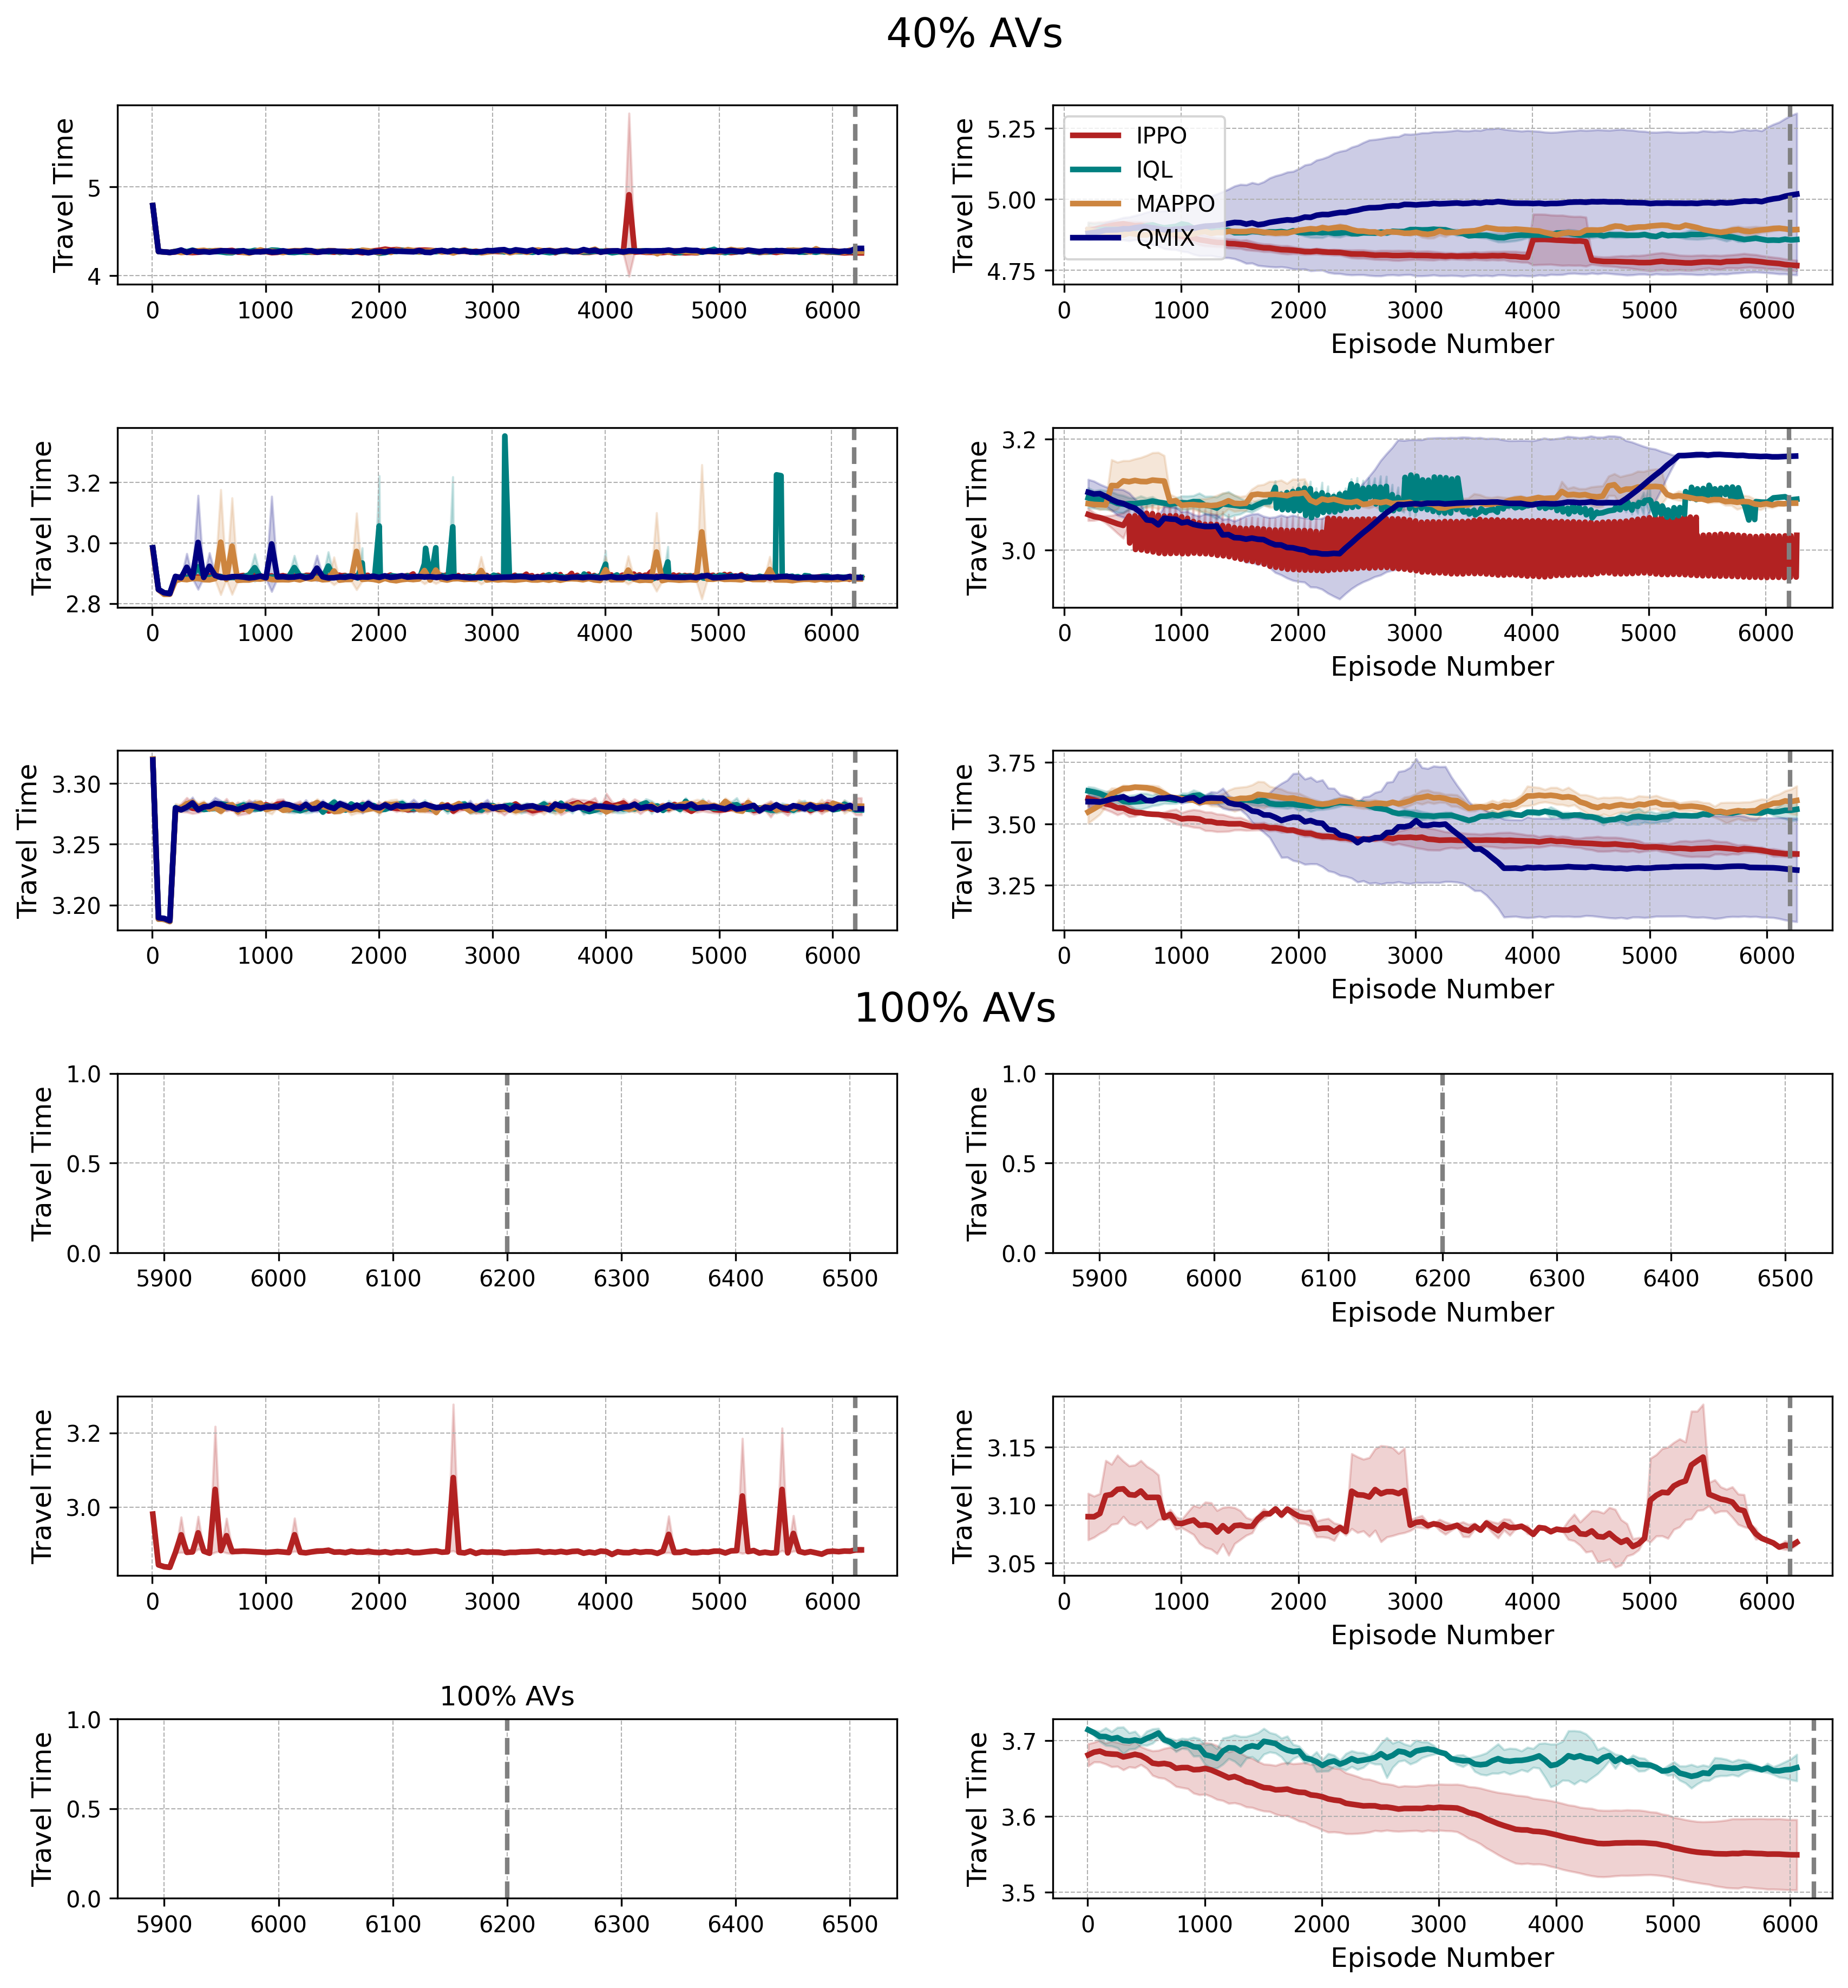

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure(figsize=(12, 12), dpi=300)

# --- Create 6x2 grid of subplots ---
axes_top = [[fig.add_subplot(6, 2, r * 2 + c + 1) for c in range(2)] for r in range(3)]
axes_bottom = [[fig.add_subplot(6, 2, (r + 3) * 2 + c + 1) for c in range(2)] for r in range(3)]

titles = ["Ingolstadt", "Provins", "Saint Arnoult"]
directories_param = [
    [
        "results/ing_ipp_0/episodes", "results/ing_ipp_1/episodes", "results/ing_ipp_2/episodes",
        "results/ing_iql_0/episodes", "results/ing_iql_1/episodes", "results/ing_iql_2/episodes",
        "results/ing_map_0/episodes", "results/ing_map_1/episodes", "results/ing_map_2/episodes",
        "results/ing_qmi_0/episodes", "results/ing_qmi_1/episodes", "results/ing_qmi_2/episodes",
    ],
    [
        "results/pro_ipp_0/episodes", "results/pro_ipp_1/episodes", "results/pro_ipp_2/episodes",
        "results/pro_iql_0/episodes", "results/pro_iql_1/episodes", "results/pro_iql_2/episodes",
        "results/pro_map_0/episodes", "results/pro_map_1/episodes", "results/pro_map_2/episodes",
        "results/pro_qmi_0/episodes", "results/pro_qmi_1/episodes", "results/pro_qmi_2/episodes",
    ],
    [
        "results/sai_ipp_0/episodes", "results/sai_ipp_1/episodes", "results/sai_ipp_2/episodes",
        "results/sai_iql_0/episodes", "results/sai_iql_1/episodes", "results/sai_iql_2/episodes",
        "results/sai_map_0/episodes", "results/sai_map_1/episodes", "results/sai_map_2/episodes",
        "results/sai_qmi_0/episodes", "results/sai_qmi_1/episodes", "results/sai_qmi_2/episodes",
    ],
]

directories_param2 = [
    [
        "results/ing_ipp2_0/episodes", "results/ing_ipp2_1/episodes", "results/ing_ipp2_2/episodes",
        "results/ing_iql2_0/episodes", "results/ing_iql2_1/episodes", "results/ing_iql2_2/episodes",
        "results/ing_map2_0/episodes", "results/ing_map2_1/episodes", "results/ing_map2_2/episodes",
        "results/ing_qmi2_0/episodes", "results/ing_qmi2_1/episodes", "results/ing_qmi2_2/episodes",
    ],
    [
        "results/pro_ipp2_0/episodes", "results/pro_ipp2_1/episodes", "results/pro_ipp2_2/episodes",
        "results/pro_iql2_0/episodes", "results/pro_iql2_1/episodes", "results/pro_iql2_2/episodes",
        "results/pro_map2_0/episodes", "results/pro_map2_1/episodes", "results/pro_map2_2/episodes",
        "results/pro_qmi2_0/episodes", "results/pro_qmi2_1/episodes", "results/pro_qmi2_2/episodes",
    ],
    [
        "results/sai_ipp2_0/episodes", "results/sai_ipp2_1/episodes", "results/sai_ipp2_2/episodes",
        "results/sai_iql2_0/episodes", "results/sai_iql2_1/episodes", "results/sai_iql2_2/episodes",
        "results/sai_map2_0/episodes", "results/sai_map2_1/episodes", "results/sai_map2_2/episodes",
        "results/sai_qmi2_0/episodes", "results/sai_qmi2_1/episodes", "results/sai_qmi2_2/episodes",
    ],
]
algorithm_names = ["IPPO"] * 3 + ["IQL"] * 3 + ["MAPPO"] * 3 + ["QMIX"] * 3

# --- Plot data into each grid ---
for i in range(3):
    # Top (human vs AV)
    plot_human_travel_times(axes_top[i][0], directories_param[i], algorithm_names)
    plot_av_travel_times(
        axes_top[i][1],
        directories=directories_param[i],
        algorithm_names=algorithm_names,
        smoothing_window=10,
        show_legend=(i == 0)
    )

    # Bottom (duplicate)
    plot_human_travel_times(axes_bottom[i][0], directories_param2[i], algorithm_names)
    plot_av_travel_times(
        axes_bottom[i][1],
        directories=directories_param2[i],
        algorithm_names=algorithm_names,
        smoothing_window=10,
        show_legend=False
    )

    #axes_bottom[i][1].set_title(f"{titles[0]} – AV (Copy)", fontsize=24)

axes_bottom[i][0].set_title(f"100% AVs", fontsize=12)


fig.text(
    0.5,        # x center (50% across)
    1,       # y position (just between top and bottom)
    "40% AVs",
    ha='center',
    fontsize=18,
)

fig.text(
    0.49,        # x center (50% across)
    0.5,       # y position (just between top and bottom)
    "100% AVs",
    ha='center',
    fontsize=18,
)


# --- Manual layout adjustment ---
fig.subplots_adjust(
    left=0.06,
    right=0.94,
    top=0.97,
    bottom=0.05,
    hspace=0.8,
    wspace=0.2
)